In [1]:
from matplotlib import pyplot
from matplotlib.image import imread

# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

In [2]:
def plot_images(kind):
    # plot dog photos from the dogs vs cats dataset
    # define location of dataset
    folder = 'train/'
    # plot first few images
    for i in range(9):
        # define subplot
        pyplot.subplot(330 + 1 + i)
        # define filename
        filename = folder + kind + '.' + str(i) + '.jpg'
        # load image pixels
        image = imread(filename)
        # plot raw pixel data
        pyplot.imshow(image)
    # show the figure
    pyplot.show()

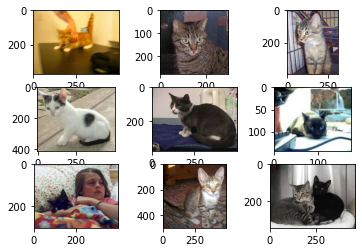

In [3]:
plot_images("cat")

In [21]:
def load_into_diff_directories():
    # create directories
    dataset_home = 'dataset_dogs_vs_cats/'
    subdirs = ['train/', 'test/']
    for subdir in subdirs:
        # create label subdirectories
        labeldirs = ['dogs/', 'cats/']
        for labldir in labeldirs:
            newdir = dataset_home + subdir + labldir
            makedirs(newdir, exist_ok=True)
            
    # seed random number generator
    seed(1)
    # define ratio of pictures to use for validation
    val_ratio = 0.25
    # copy training dataset images into subdirectories
    src_directory = 'train_dataset/'
    for file in listdir(src_directory):
        src = src_directory + '/' + file
        dst_dir = 'train/'
        if random() < val_ratio:
            dst_dir = 'test/'
        if file.startswith('cat'):
            dst = dataset_home + dst_dir + 'cats/'  + file
            copyfile(src, dst)
        elif file.startswith('dog'):
            dst = dataset_home + dst_dir + 'dogs/'  + file
            copyfile(src, dst)

In [22]:
load_into_diff_directories()

In [72]:
# baseline model for the dogs vs cats dataset
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [81]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', 
                     input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
#     opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [82]:
# define model
model = define_model()

# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

#     # prepare iterators - Without Data Augmentation 
#     train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
#         class_mode='binary', batch_size=64, target_size=(200, 200))
#     test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
#         class_mode='binary', batch_size=64, target_size=(200, 200))

# create data generators - For Data Augmentation 
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True
                                  )

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_data = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/', 
                                               class_mode='binary', 
                                               batch_size=32, 
                                               target_size=(224, 224)
                                              )

test_data = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/', 
                                           class_mode='binary', 
                                           batch_size=32, 
                                           target_size=(224, 224)
                                          )

Found 295 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


In [83]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 112, 112, 64)    

In [84]:
# fit model
early_stopping_cb = EarlyStopping(monitor='val_accuracy', 
                                  patience=10, 
                                  restore_best_weights=True)

history = model.fit(x = train_data, 
                    steps_per_epoch=len(train_data), 
                    validation_data=test_data, 
                    validation_steps=len(test_data), 
                    callbacks=[early_stopping_cb],
                    epochs=20, 
                    verbose=0
                   )

In [85]:
# evaluate model
_, acc = model.evaluate(test_data, steps=len(test_data), verbose=0)
print('> The accuracy is: %.3f' % (acc * 100.0))

> The accuracy is: 53.704


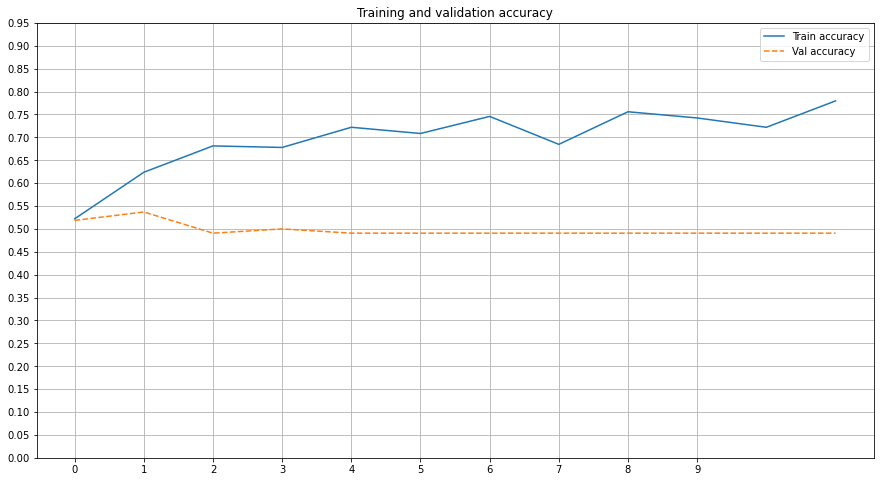

In [86]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

plt.figure(figsize=(15,8))
plt.plot(loss, label='Train accuracy')
plt.plot(val_loss,'--', label='Val accuracy')
plt.title('Training and validation accuracy')
plt.xticks(np.arange(0,10))
plt.yticks(np.arange(0, 1.0, 0.05));
plt.grid()
plt.legend();

In [87]:
def load_image(filename):
    img = load_img(filename, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape(1, 224, 224, 3)
    
    # center pixel data
    img = img.astype('float32')
    img = img - [123.68, 116.779, 103.939]
    return img

In [88]:
img = load_image('sample4.jpg')

# model = tf.keras.models.load_model('dog_vs_cat_model.h5')
result = model.predict(img)
print(result[0])

1/1 [==============================] - 0s 96ms/step
[1.]
